# Statistical Research

### 1) Download libraries and modules

In [68]:
import pandas as pd
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from pyod.models.copod import COPOD
from pyod.models.iforest import IForest
from tsfresh.feature_extraction import extract_features, EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute
from tsfresh import extract_features
from scipy.stats import spearmanr, kendalltau
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from pathlib import Path
from typing import Dict, Tuple, List, Optional
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance

In [69]:
def project_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for candidate in [p, *p.parents]:
        if (candidate / "pyproject.toml").exists():
            return candidate
    return p

### 2) Download train data 

We first make data usable by downloading it into a Polars dataframeº

In [70]:
root_path = project_root()
# 160,000 rows error fix 
train_data_1 = pd.read_csv(root_path / "data" / "train.csv")
train_data_2 = pd.read_csv(root_path / "data" / "train_new.csv") # in windows, use "\"

merged_data = pd.concat([train_data_1, train_data_2], axis=1)
columns = [col for col in merged_data.columns if col not in ['Y1', 'Y2']] + ['Y1', 'Y2']
merged_data = merged_data[columns]
train_data = pl.DataFrame(merged_data).with_columns(pl.col("time").cast(int)).fill_null(-1)
merged_data = merged_data.set_index("time")
merged_data.to_csv(root_path / "data" / "full_train_data.csv")
print("TRAIN DATA\n")
print(train_data)
print("TRAIN DATA\n")
print(train_data.head())

print("TEST DATA\n")
test_data = pl.read_csv(root_path / "data" / "test.csv")
print(test_data.head())


TRAIN DATA

shape: (80_000, 19)
┌───────┬───────────┬───────────┬───────────┬───┬──────┬──────┬───────────┬───────────┐
│ time  ┆ A         ┆ B         ┆ C         ┆ … ┆ O    ┆ P    ┆ Y1        ┆ Y2        │
│ ---   ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---  ┆ ---  ┆ ---       ┆ ---       │
│ i64   ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64  ┆ f64  ┆ f64       ┆ f64       │
╞═══════╪═══════════╪═══════════╪═══════════╪═══╪══════╪══════╪═══════════╪═══════════╡
│ 0     ┆ 0.207366  ┆ -0.159951 ┆ -0.634176 ┆ … ┆ -1.0 ┆ -1.0 ┆ -0.935902 ┆ -0.310081 │
│ 1     ┆ 0.188828  ┆ -0.265508 ┆ 0.042143  ┆ … ┆ -1.0 ┆ -1.0 ┆ -0.089707 ┆ -0.305374 │
│ 2     ┆ -0.144261 ┆ -0.577142 ┆ -0.214634 ┆ … ┆ -1.0 ┆ -1.0 ┆ -0.077855 ┆ -0.631485 │
│ 3     ┆ 0.208982  ┆ -0.310449 ┆ 0.513708  ┆ … ┆ -1.0 ┆ 0.0  ┆ 0.941271  ┆ -0.535212 │
│ 4     ┆ 0.09332   ┆ -0.358156 ┆ 0.173188  ┆ … ┆ -1.0 ┆ -1.0 ┆ -0.039582 ┆ -0.490561 │
│ …     ┆ …         ┆ …         ┆ …         ┆ … ┆ …    ┆ …    ┆ …         ┆ …         │


### 3) Visualize Relationship betweeen Targets and Explanatory Variables

Plot features dependency with the variables into scatter plot grids

In [71]:
def plot_grid_vs_target(target: np.ndarray, label: str, num_rows: int, num_cols: int, columns_to_plot: List[str], colour: str):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axes = np.atleast_1d(axes).ravel()
    corr_dict = {}
    y = np.asarray(target, dtype=float)

    for i, col in enumerate(columns_to_plot):
        ax = axes[i]
        x = np.asarray(train_data[col], dtype=float)

        m = np.isfinite(x) & np.isfinite(y)
        corr = np.corrcoef(x[m], y[m])[0, 1] if m.any() else np.nan

        corr_dict[col] = corr

        ax.scatter(x[m], y[m], alpha=0.5, color=colour)
        ax.set_title(f"{col} vs {label}\ncorr={corr:.4f}" if np.isfinite(corr) else f"{col} vs {label}\ncorr=nan")
        ax.set_xlabel(col)
        ax.set_ylabel(label)

    for j in range(len(columns_to_plot), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"Features vs {label}", y=0.995, fontsize=16)
    fig.tight_layout()
    plt.show()
    return corr_dict
    

def superpose_grids(targets: List[np.ndarray], labels: List[str], num_rows: int, num_cols: int, columns_to_plot: List[str], colours: List[str]):

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(columns_to_plot):
        ax = axes[i]
        x = np.asarray(train_data[col].to_numpy(), dtype=float).ravel()
        corrs = [] 

        for num, target in enumerate(targets):
            y = np.asarray(target, dtype=float).ravel()
            m = np.isfinite(x) & np.isfinite(y)
            if m.sum() >= 2 and np.std(x[m]) > 0 and np.std(y[m]) > 0:
                c = np.corrcoef(x[m], y[m])[0, 1]
            else:
                c = np.nan

            corrs.append(c)
            ax.scatter(x[m], y[m], alpha=0.5, label=labels[num], color=colours[num])
    

        corr_txt = "  |  ".join(
            f"corr({lbl})={c:.4f}" if np.isfinite(c) else f"corr({lbl})=nan"
            for lbl, c in zip(labels, corrs)
        )
        ax.set_title(f"{col} vs targets\n{corr_txt}")
        ax.set_xlabel(col)
        ax.set_ylabel("target")
        ax.legend(loc="best")

    for j in range(len(columns_to_plot), len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    plt.show()


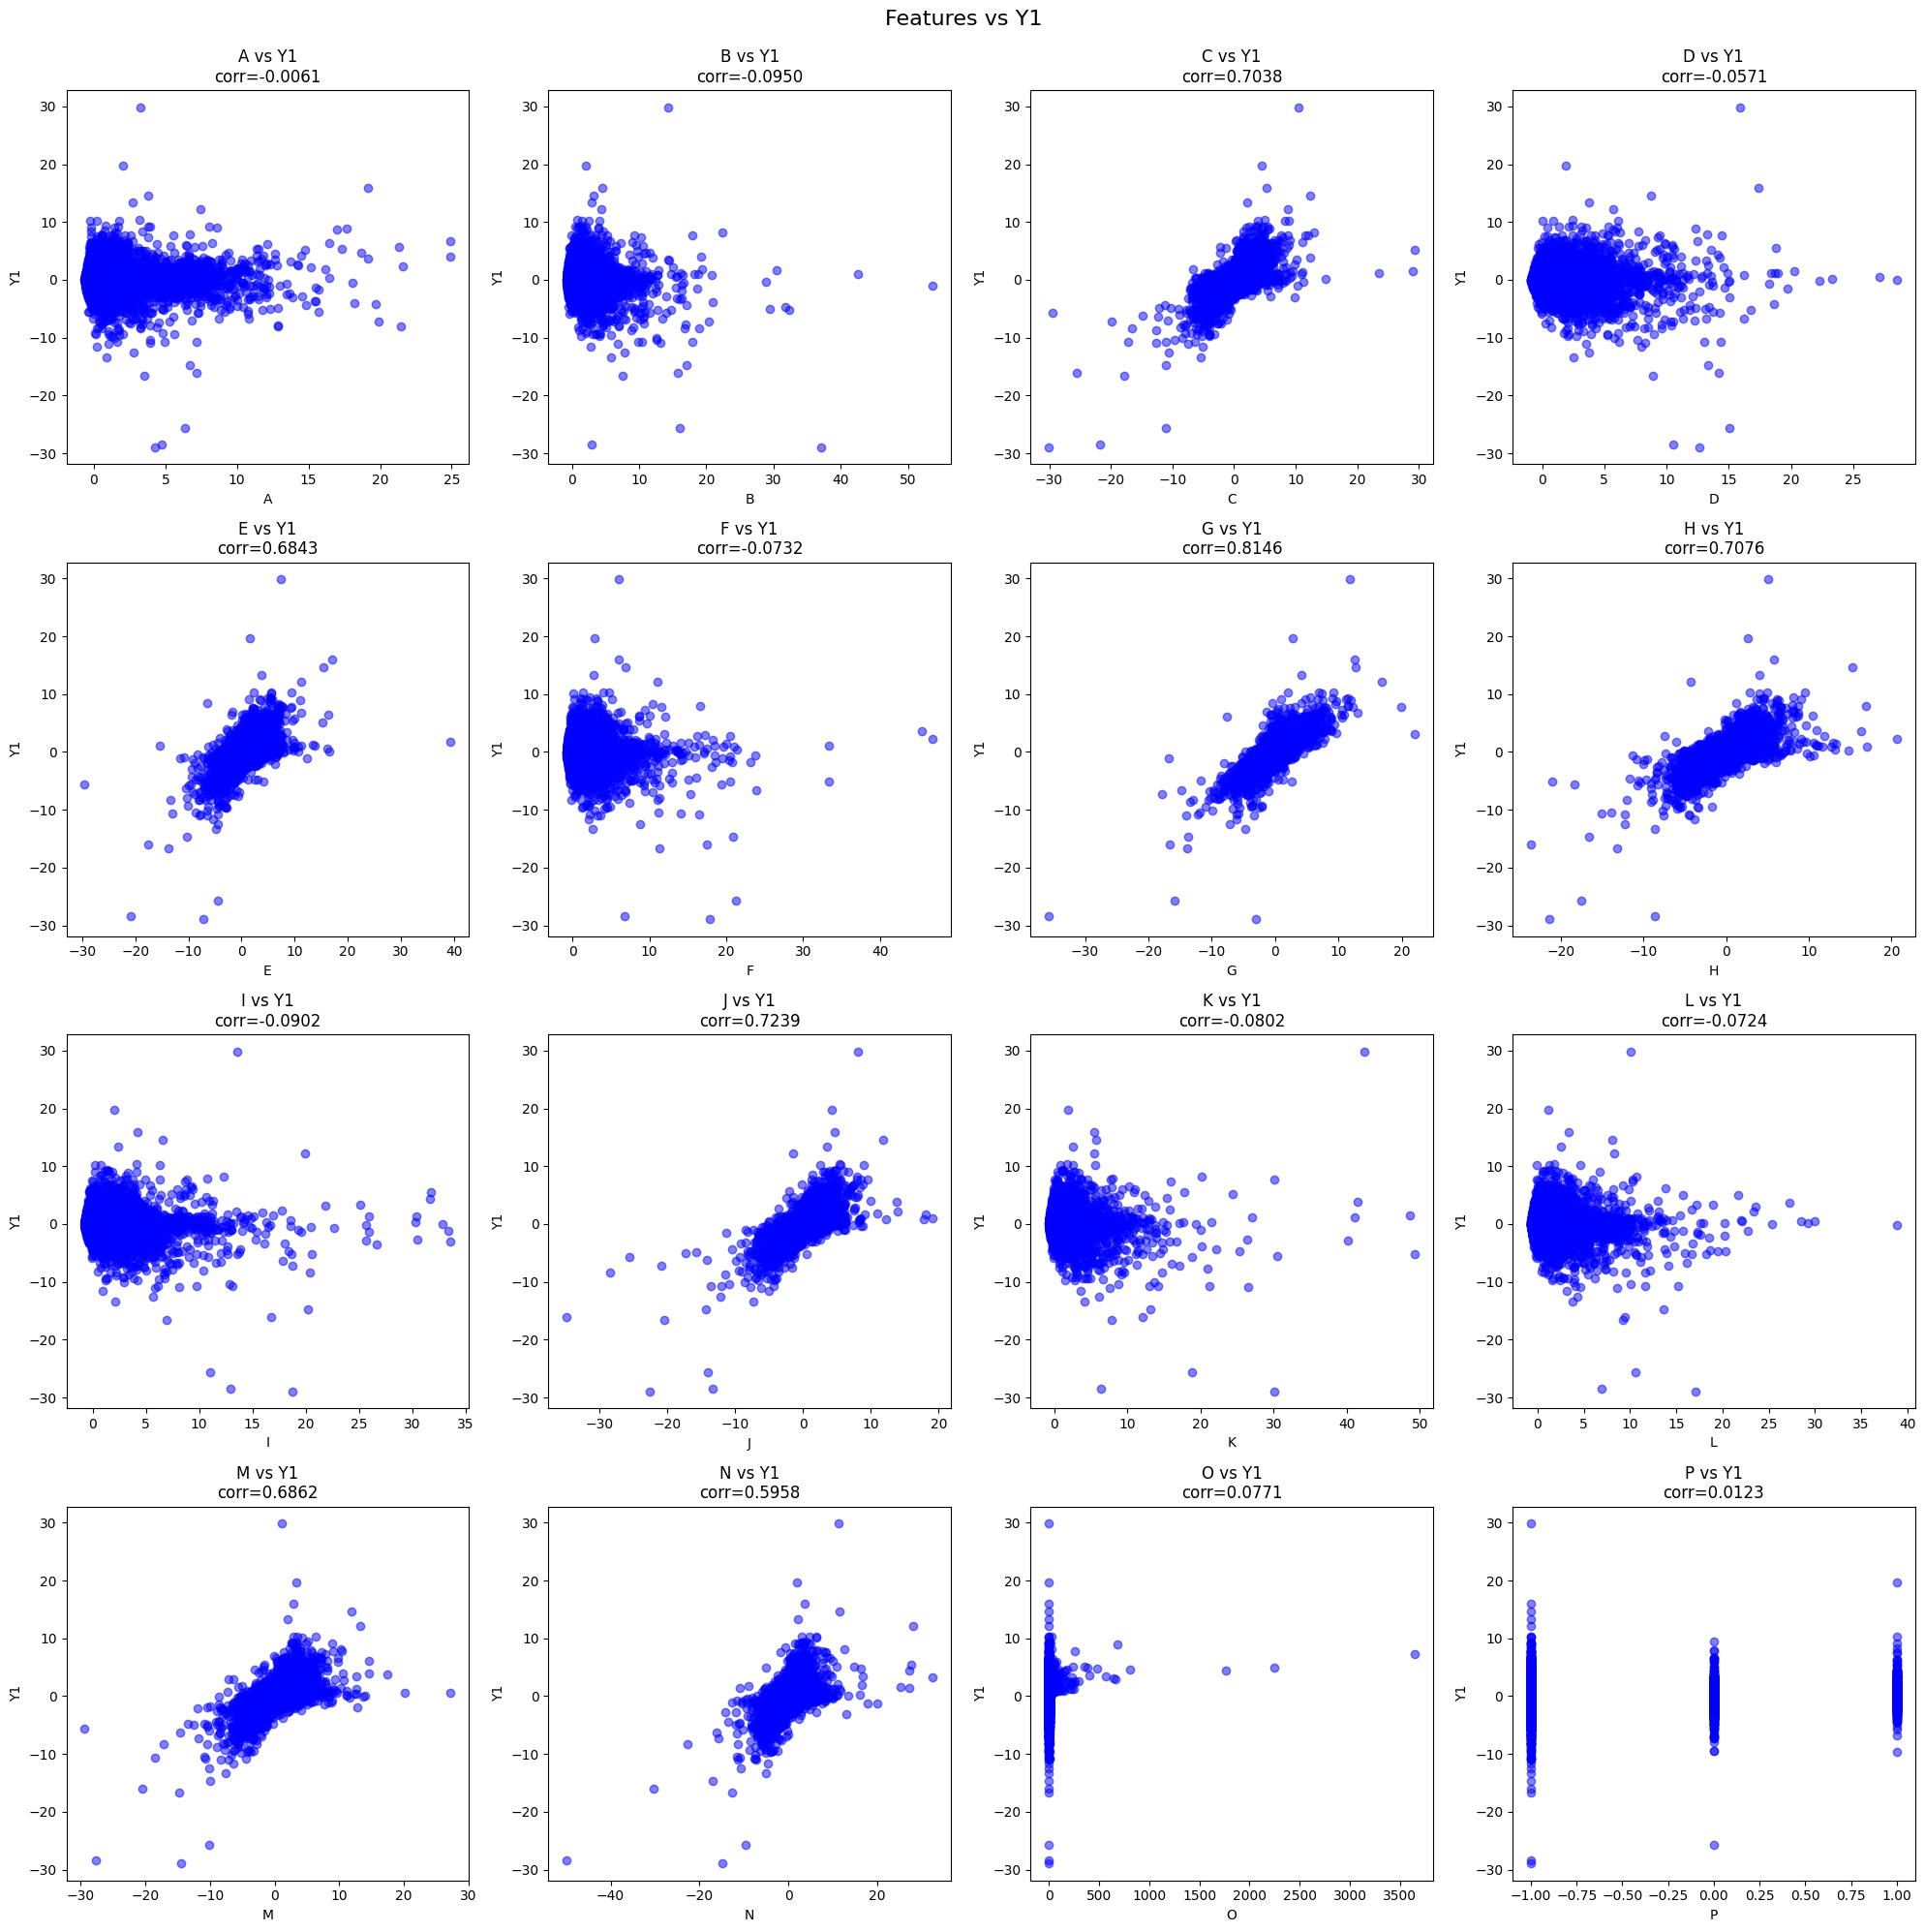

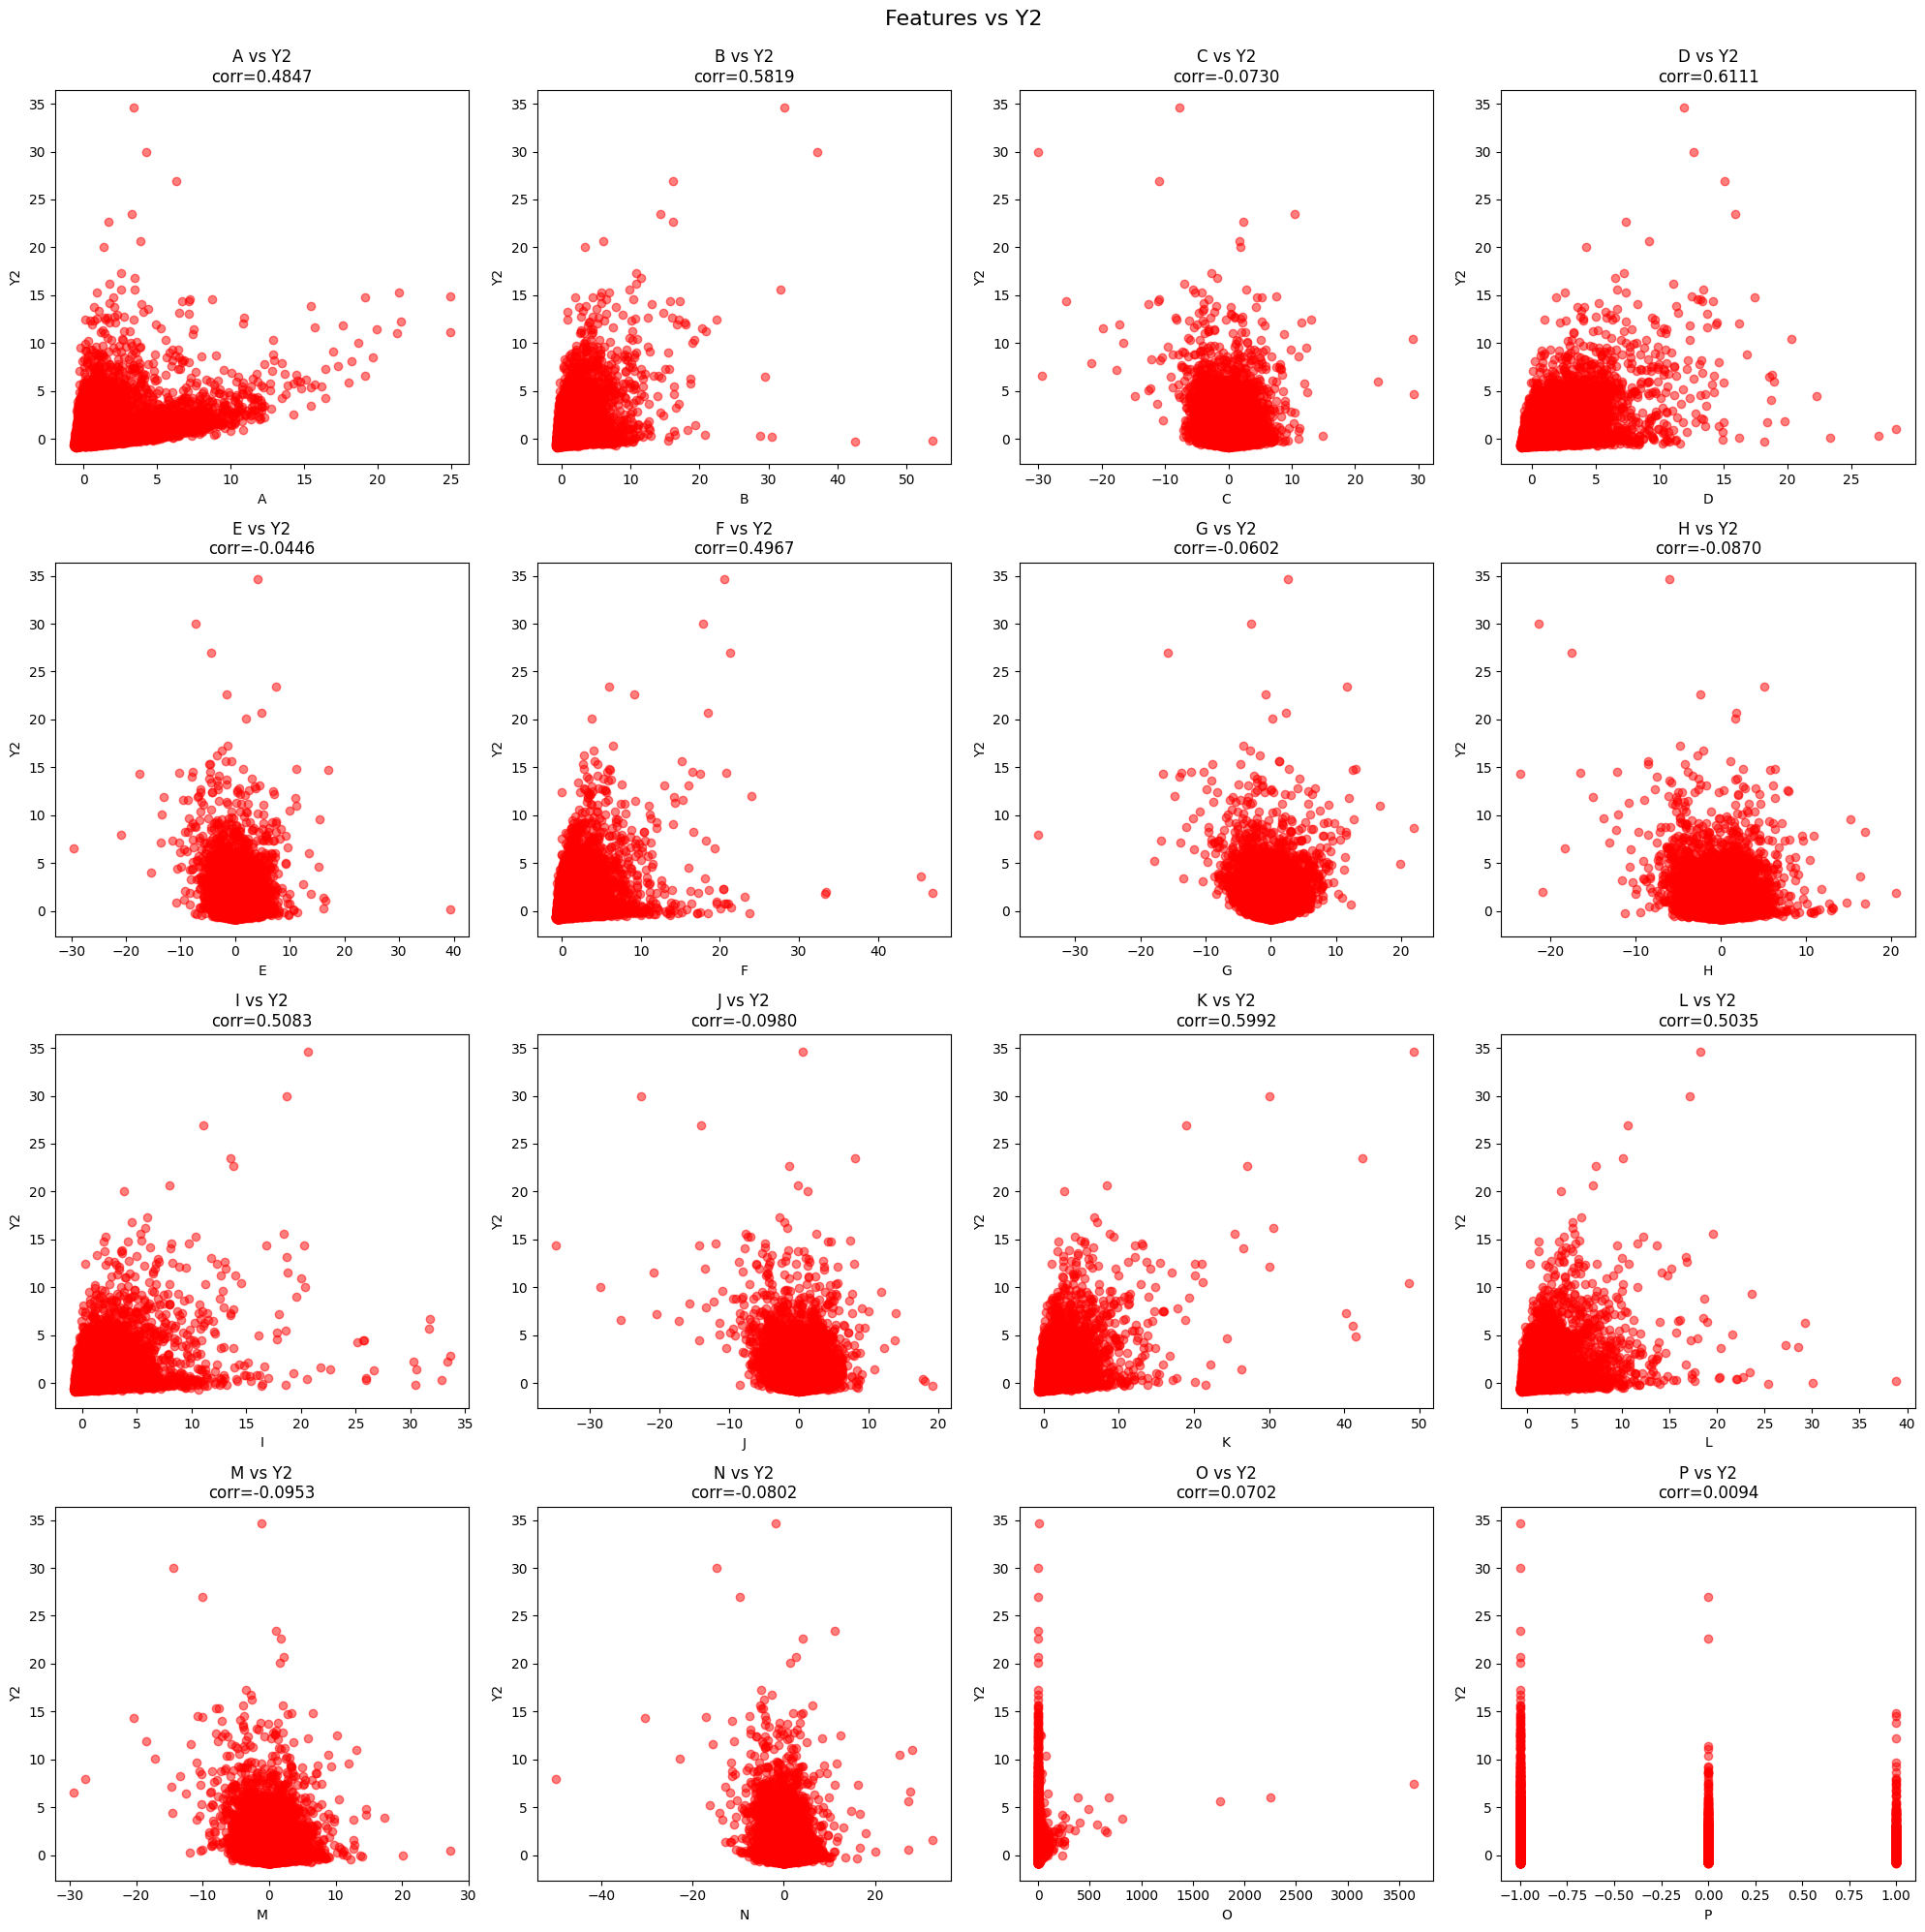

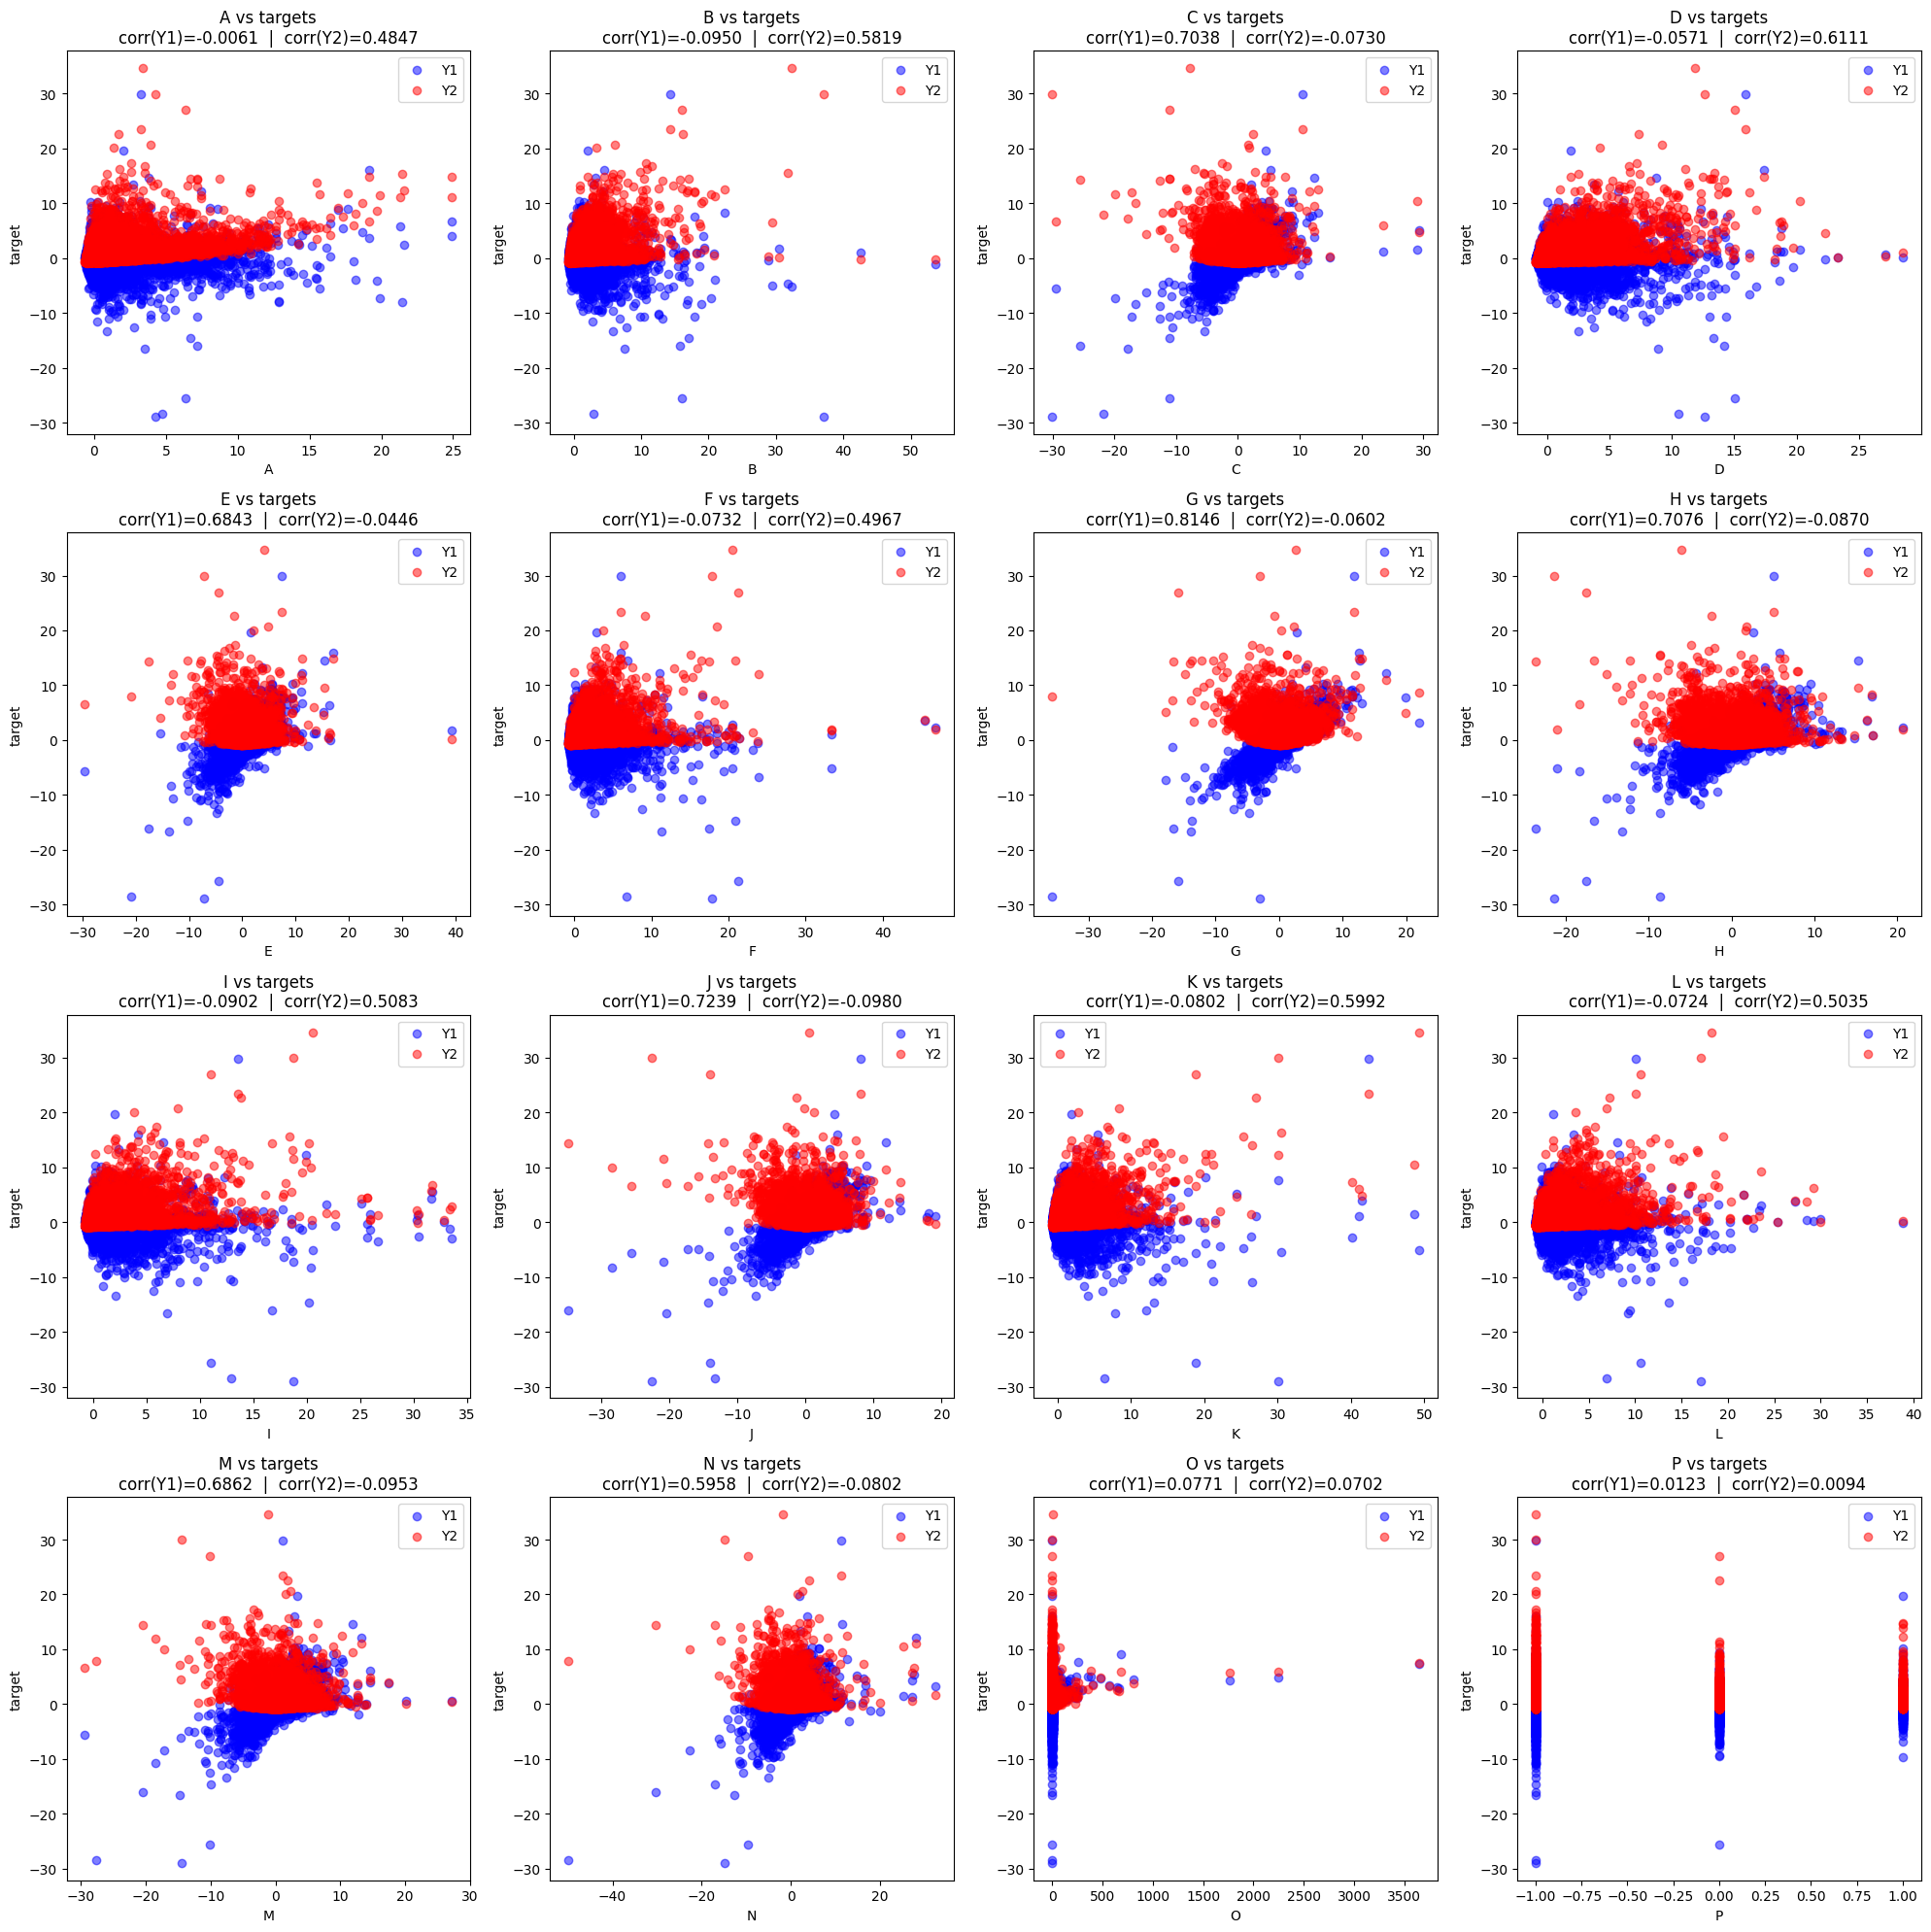

In [72]:
columns_to_plot = [c for c in columns if c not in ['time', 'Y1', 'Y2']]
num_cols = 4
num_rows = -(-len(columns_to_plot) // num_cols)
list_targets = [train_data["Y1"].to_numpy(),train_data["Y2"].to_numpy()]

correlation_dict_Y1 = plot_grid_vs_target(list_targets[0], "Y1", num_rows, num_cols, columns_to_plot, "blue")
print("\n")
correlation_dict_Y2 = plot_grid_vs_target(list_targets[1], "Y2", num_rows, num_cols, columns_to_plot, "red")
print("\n")
superpose_grids(list_targets, ["Y1","Y2"], num_rows, num_cols, columns_to_plot, ["blue","red"])

In [73]:
correlation_df = pd.DataFrame({
    'Correlation Y1': pd.Series(correlation_dict_Y1, dtype=float),
    'Correlation Y2': pd.Series(correlation_dict_Y2, dtype=float),
})
correlation_df = correlation_df.fillna(0.0)

correlation_df['abs_Y1'] = correlation_df['Correlation Y1'].abs()
correlation_df['abs_Y2'] = correlation_df['Correlation Y2'].abs()

correlation_df['score_l2'] = np.hypot(
    correlation_df['Correlation Y1'],
    correlation_df['Correlation Y2']
)

correlation_df['score_max'] = correlation_df[['abs_Y1', 'abs_Y2']].max(axis=1)
correlation_df['score_mean'] = correlation_df[['abs_Y1', 'abs_Y2']].mean(axis=1)

top_by_Y1 = correlation_df.sort_values('abs_Y1', ascending=False)

top_by_Y2 = correlation_df.sort_values('abs_Y2', ascending=False)

top_by_both = correlation_df.sort_values('score_l2', ascending=False).reset_index()
top_by_both = top_by_both.rename(columns={"index": "feature"})
pl_df = pl.from_pandas(top_by_both)

print("Top by both (L2):\n")
print(pl_df.head(20))

Top by both (L2):

shape: (16, 8)
┌─────────┬───────────────┬──────────────┬──────────┬──────────┬──────────┬───────────┬────────────┐
│ feature ┆ Correlation   ┆ Correlation  ┆ abs_Y1   ┆ abs_Y2   ┆ score_l2 ┆ score_max ┆ score_mean │
│ ---     ┆ Y1            ┆ Y2           ┆ ---      ┆ ---      ┆ ---      ┆ ---       ┆ ---        │
│ str     ┆ ---           ┆ ---          ┆ f64      ┆ f64      ┆ f64      ┆ f64       ┆ f64        │
│         ┆ f64           ┆ f64          ┆          ┆          ┆          ┆           ┆            │
╞═════════╪═══════════════╪══════════════╪══════════╪══════════╪══════════╪═══════════╪════════════╡
│ G       ┆ 0.814568      ┆ -0.060187    ┆ 0.814568 ┆ 0.060187 ┆ 0.816788 ┆ 0.814568  ┆ 0.437377   │
│ J       ┆ 0.723921      ┆ -0.097986    ┆ 0.723921 ┆ 0.097986 ┆ 0.730522 ┆ 0.723921  ┆ 0.410953   │
│ H       ┆ 0.70756       ┆ -0.086976    ┆ 0.70756  ┆ 0.086976 ┆ 0.712885 ┆ 0.70756   ┆ 0.397268   │
│ C       ┆ 0.703823      ┆ -0.073009    ┆ 0.703823 ┆ 0.0

Many feature–target relations in the scatter plots look non-linear, so Pearson (linear) correlation can miss signal. Alternatives:
- Spearman's rho: rank-based; captures monotonic but non-linear relationships.
- Kendall's tau: rank-based; more robust to outliers but slower on large data.
- Mutual information (MI): model-free dependency measure; captures arbitrary non-linear relations (non-negative).

Below, compute Spearman, Kendall, and MI for each feature vs `Y1` and `Y2`, then rank features by these scores.

In [74]:
def rank_corr_series(X_col, y, method):
    m = X_col.notna() & y.notna()
    if m.sum() < 3:
        return np.nan
    if method == 'spearman':
        rho, _ = spearmanr(X_col[m], y[m])
        return rho
    elif method == 'kendall':
        tau, _ = kendalltau(X_col[m], y[m])
        return tau
    else:
        raise ValueError('method must be spearman or kendall')

In [75]:
feature_cols = [c for c in train_data.columns if c not in ['time']]
X = merged_data[feature_cols]
y1 = merged_data['Y1']
y2 = merged_data['Y2']

spearman_y1 = {c: rank_corr_series(X[c], y1, 'spearman') for c in feature_cols}
spearman_y2 = {c: rank_corr_series(X[c], y2, 'spearman') for c in feature_cols}
kendall_y1 = {c: rank_corr_series(X[c], y1, 'kendall') for c in feature_cols}
kendall_y2 = {c: rank_corr_series(X[c], y2, 'kendall') for c in feature_cols}

X_num = X.select_dtypes(include=['number']).copy()

X_num = X_num.fillna(X_num.median(numeric_only=True))
y1_filled = y1.fillna(y1.median())
y2_filled = y2.fillna(y2.median())

mi_y1 = mutual_info_regression(X_num.values, y1_filled.values, random_state=0)
mi_y2 = mutual_info_regression(X_num.values, y2_filled.values, random_state=0)
mi_y1 = pd.Series(mi_y1, index=X_num.columns)
mi_y2 = pd.Series(mi_y2, index=X_num.columns)

nl_df = pd.DataFrame({
    'spearman_Y1': pd.Series(spearman_y1),
    'spearman_Y2': pd.Series(spearman_y2),
    'kendall_Y1': pd.Series(kendall_y1),
    'kendall_Y2': pd.Series(kendall_y2),
}).fillna(0.0)

nl_df['MI_Y1'] = 0.0
nl_df['MI_Y2'] = 0.0
for col in X_num.columns:
    nl_df.loc[col, 'MI_Y1'] = mi_y1[col]
    nl_df.loc[col, 'MI_Y2'] = mi_y2[col]

nl_df['rank_strength_Y1'] = nl_df['spearman_Y1'].abs().rank(ascending=False, method='average')
nl_df['rank_strength_Y2'] = nl_df['spearman_Y2'].abs().rank(ascending=False, method='average')
nl_df['rank_MI_Y1'] = nl_df['MI_Y1'].rank(ascending=False, method='average')
nl_df['rank_MI_Y2'] = nl_df['MI_Y2'].rank(ascending=False, method='average')
nl_df['rank_overall'] = (nl_df['rank_strength_Y1'] + nl_df['rank_MI_Y1'] + nl_df['rank_strength_Y2'] + nl_df['rank_MI_Y2']) / 4.0
nl_df_reset = nl_df.reset_index()
nl_df_reset = nl_df_reset.rename(columns={"index": "feature"})
nl_pl = pl.from_pandas(nl_df_reset)
print("CORRELATIONS WITH RANKING")
print(nl_pl)

top_spearman_Y1 = pl.from_pandas(nl_df.sort_values('spearman_Y1', key=lambda s: s.abs(), ascending=False).head(20).reset_index().rename(columns={"index": "feature"}))
top_spearman_Y2 =  pl.from_pandas(nl_df.sort_values('spearman_Y2', key=lambda s: s.abs(), ascending=False).head(20).reset_index().rename(columns={"index": "feature"}))
top_mi_Y1 =  pl.from_pandas(nl_df.sort_values('MI_Y1', ascending=False).head(20).reset_index().rename(columns={"index": "feature"}))
top_mi_Y2 =  pl.from_pandas(nl_df.sort_values('MI_Y2', ascending=False).head(20).reset_index().rename(columns={"index": "feature"}))
top_overall =  pl.from_pandas(nl_df.sort_values('rank_overall').head(20).reset_index().rename(columns={"index": "feature"}))


print('\nTop Spearman (Y1):\n')
print(top_spearman_Y1[:,['feature','spearman_Y1']])
print('\nTop Spearman (Y2):\n')
print(top_spearman_Y2[:,['feature','spearman_Y2']])
print('\nTop Mutual Information (Y1):\n')
print(top_mi_Y1[:,['feature','spearman_Y1']])
print('\nTop Mutual Information (Y2):\n')
print(top_mi_Y2[:,['feature','spearman_Y2']])
print('\nTop Overall (avg rank of Spearman & MI for Y1 and Y2):\n')
print(top_overall[:,['feature','spearman_Y1','spearman_Y2']])

CORRELATIONS WITH RANKING
shape: (18, 12)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ feature ┆ spearman_Y ┆ spearman_ ┆ kendall_Y ┆ … ┆ rank_stre ┆ rank_MI_Y ┆ rank_MI_Y ┆ rank_over │
│ ---     ┆ 1          ┆ Y2        ┆ 1         ┆   ┆ ngth_Y2   ┆ 1         ┆ 2         ┆ all       │
│ str     ┆ ---        ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│         ┆ f64        ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ A       ┆ -0.002308  ┆ 0.609209  ┆ -0.00138  ┆ … ┆ 5.0       ┆ 14.0      ┆ 2.0       ┆ 9.75      │
│ B       ┆ -0.021435  ┆ 0.62362   ┆ -0.013819 ┆ … ┆ 3.0       ┆ 12.0      ┆ 4.0       ┆ 8.25      │
│ C       ┆ 0.695609   ┆ -0.00963  ┆ 0.522716  ┆ … ┆ 17.0      ┆ 5.0       ┆ 12.0      ┆ 10.0      │
│ D       ┆ -0.016948  ┆ 0.612065  ┆ -0.011279 ┆ 

### 4) Visualize Relationships among Explanatory Variables

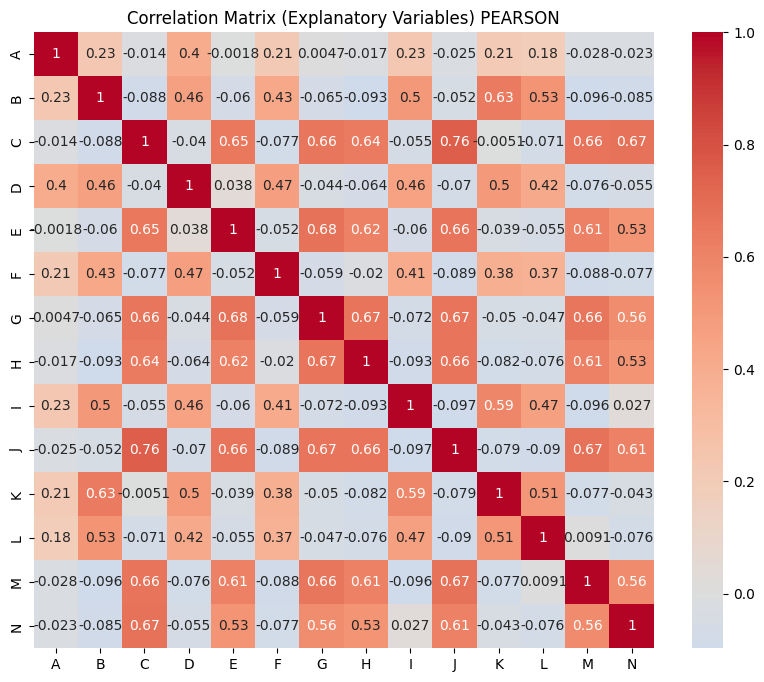

In [78]:
corr_matrix = train_data.to_pandas().drop(columns=["O","P","Y1", "Y2", "time"]).corr(method="pearson")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Explanatory Variables) PEARSON")
plt.show()

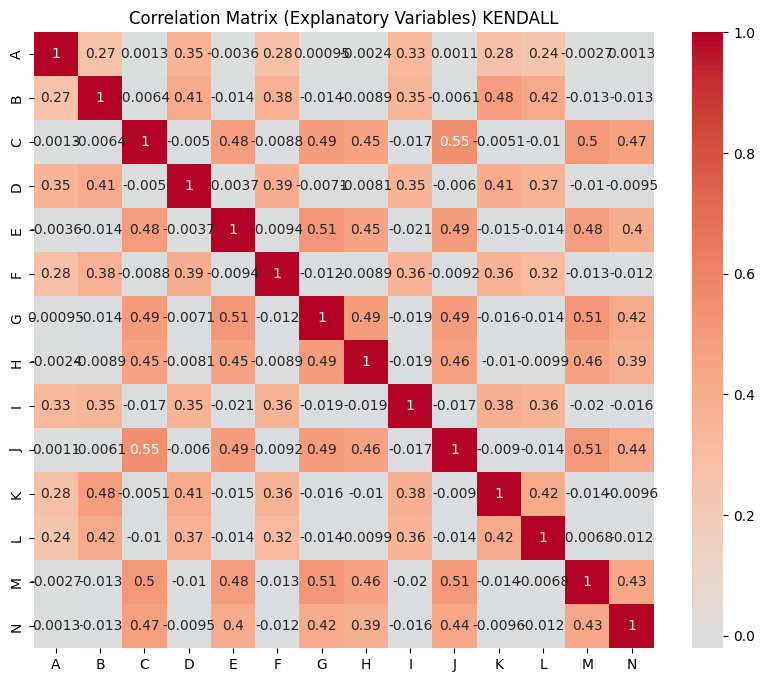

In [79]:
corr_matrix = train_data.to_pandas().drop(columns=["O","P","Y1", "Y2", "time"]).corr(method="kendall")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Explanatory Variables) KENDALL")
plt.show()

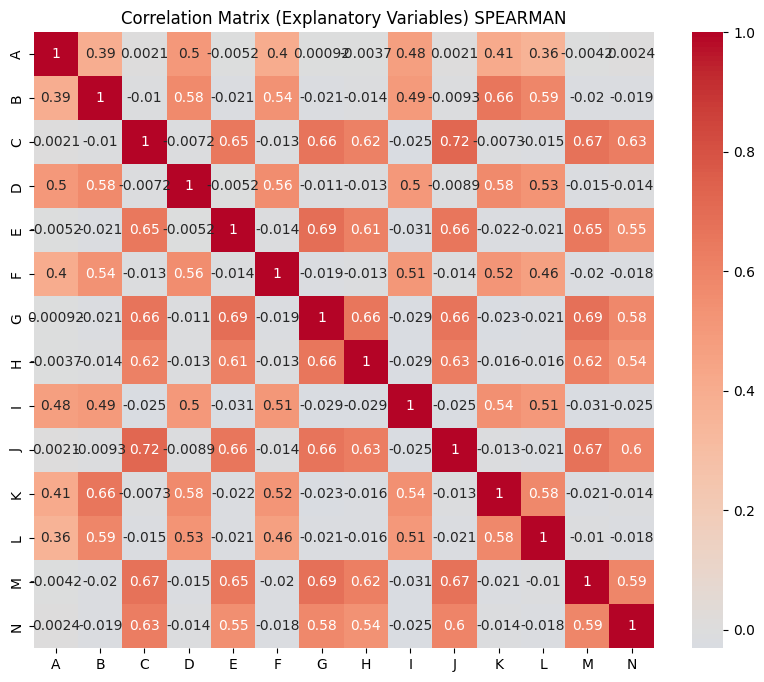

In [80]:
corr_matrix = train_data.to_pandas().drop(columns=["O","P","Y1", "Y2", "time"]).corr(method="spearman")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Explanatory Variables) SPEARMAN")
plt.show()

### 5) Visualize Distributions

Now compute the histograms deleting the outlier to see distributions better

In [81]:
def generate_hist(df: pl.DataFrame, bins: int = 100, cols: int = 4, clip_mode: str = "quantile", q_low: float = 0.01, q_high: float = 0.99, iqr_k: float = 1.5, log_y: bool = False):

    feature_cols = [c for c in df.columns]
    n = len(feature_cols)

    cols = 4
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for i, col in enumerate(feature_cols):
        ax = axes[i]

        s = pd.to_numeric(df[col].to_pandas(), errors="coerce").dropna()
        if s.empty:
            ax.set_visible(False)
            continue

        if clip_mode == "quantile":
            low, high = s.quantile(q_low), s.quantile(q_high)
        else:  # IQR
            q1, q3 = s.quantile(0.25), s.quantile(0.75)
            iqr = q3 - q1
            low, high = q1 - iqr_k * iqr, q3 + iqr_k * iqr

        s_clipped = s[(s >= low) & (s <= high)]
        clipped_pct = 0.0 if len(s) == 0 else 100.0 * (1.0 - len(s_clipped) / len(s))

        ax.hist(s_clipped,bins=bins,color="steelblue",alpha=0.9,edgecolor="white",density=True)

        ax.set_title(
            f"Histogram of {col}\n[{low:.3g}, {high:.3g}] | outlier pct {clipped_pct:.3f}%"
        )
        ax.set_xlabel(col)
        ax.set_ylabel("Density")
        ax.set_xlim(low, high)

        if log_y:
            ax.set_yscale("log")

    for j in range(n, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


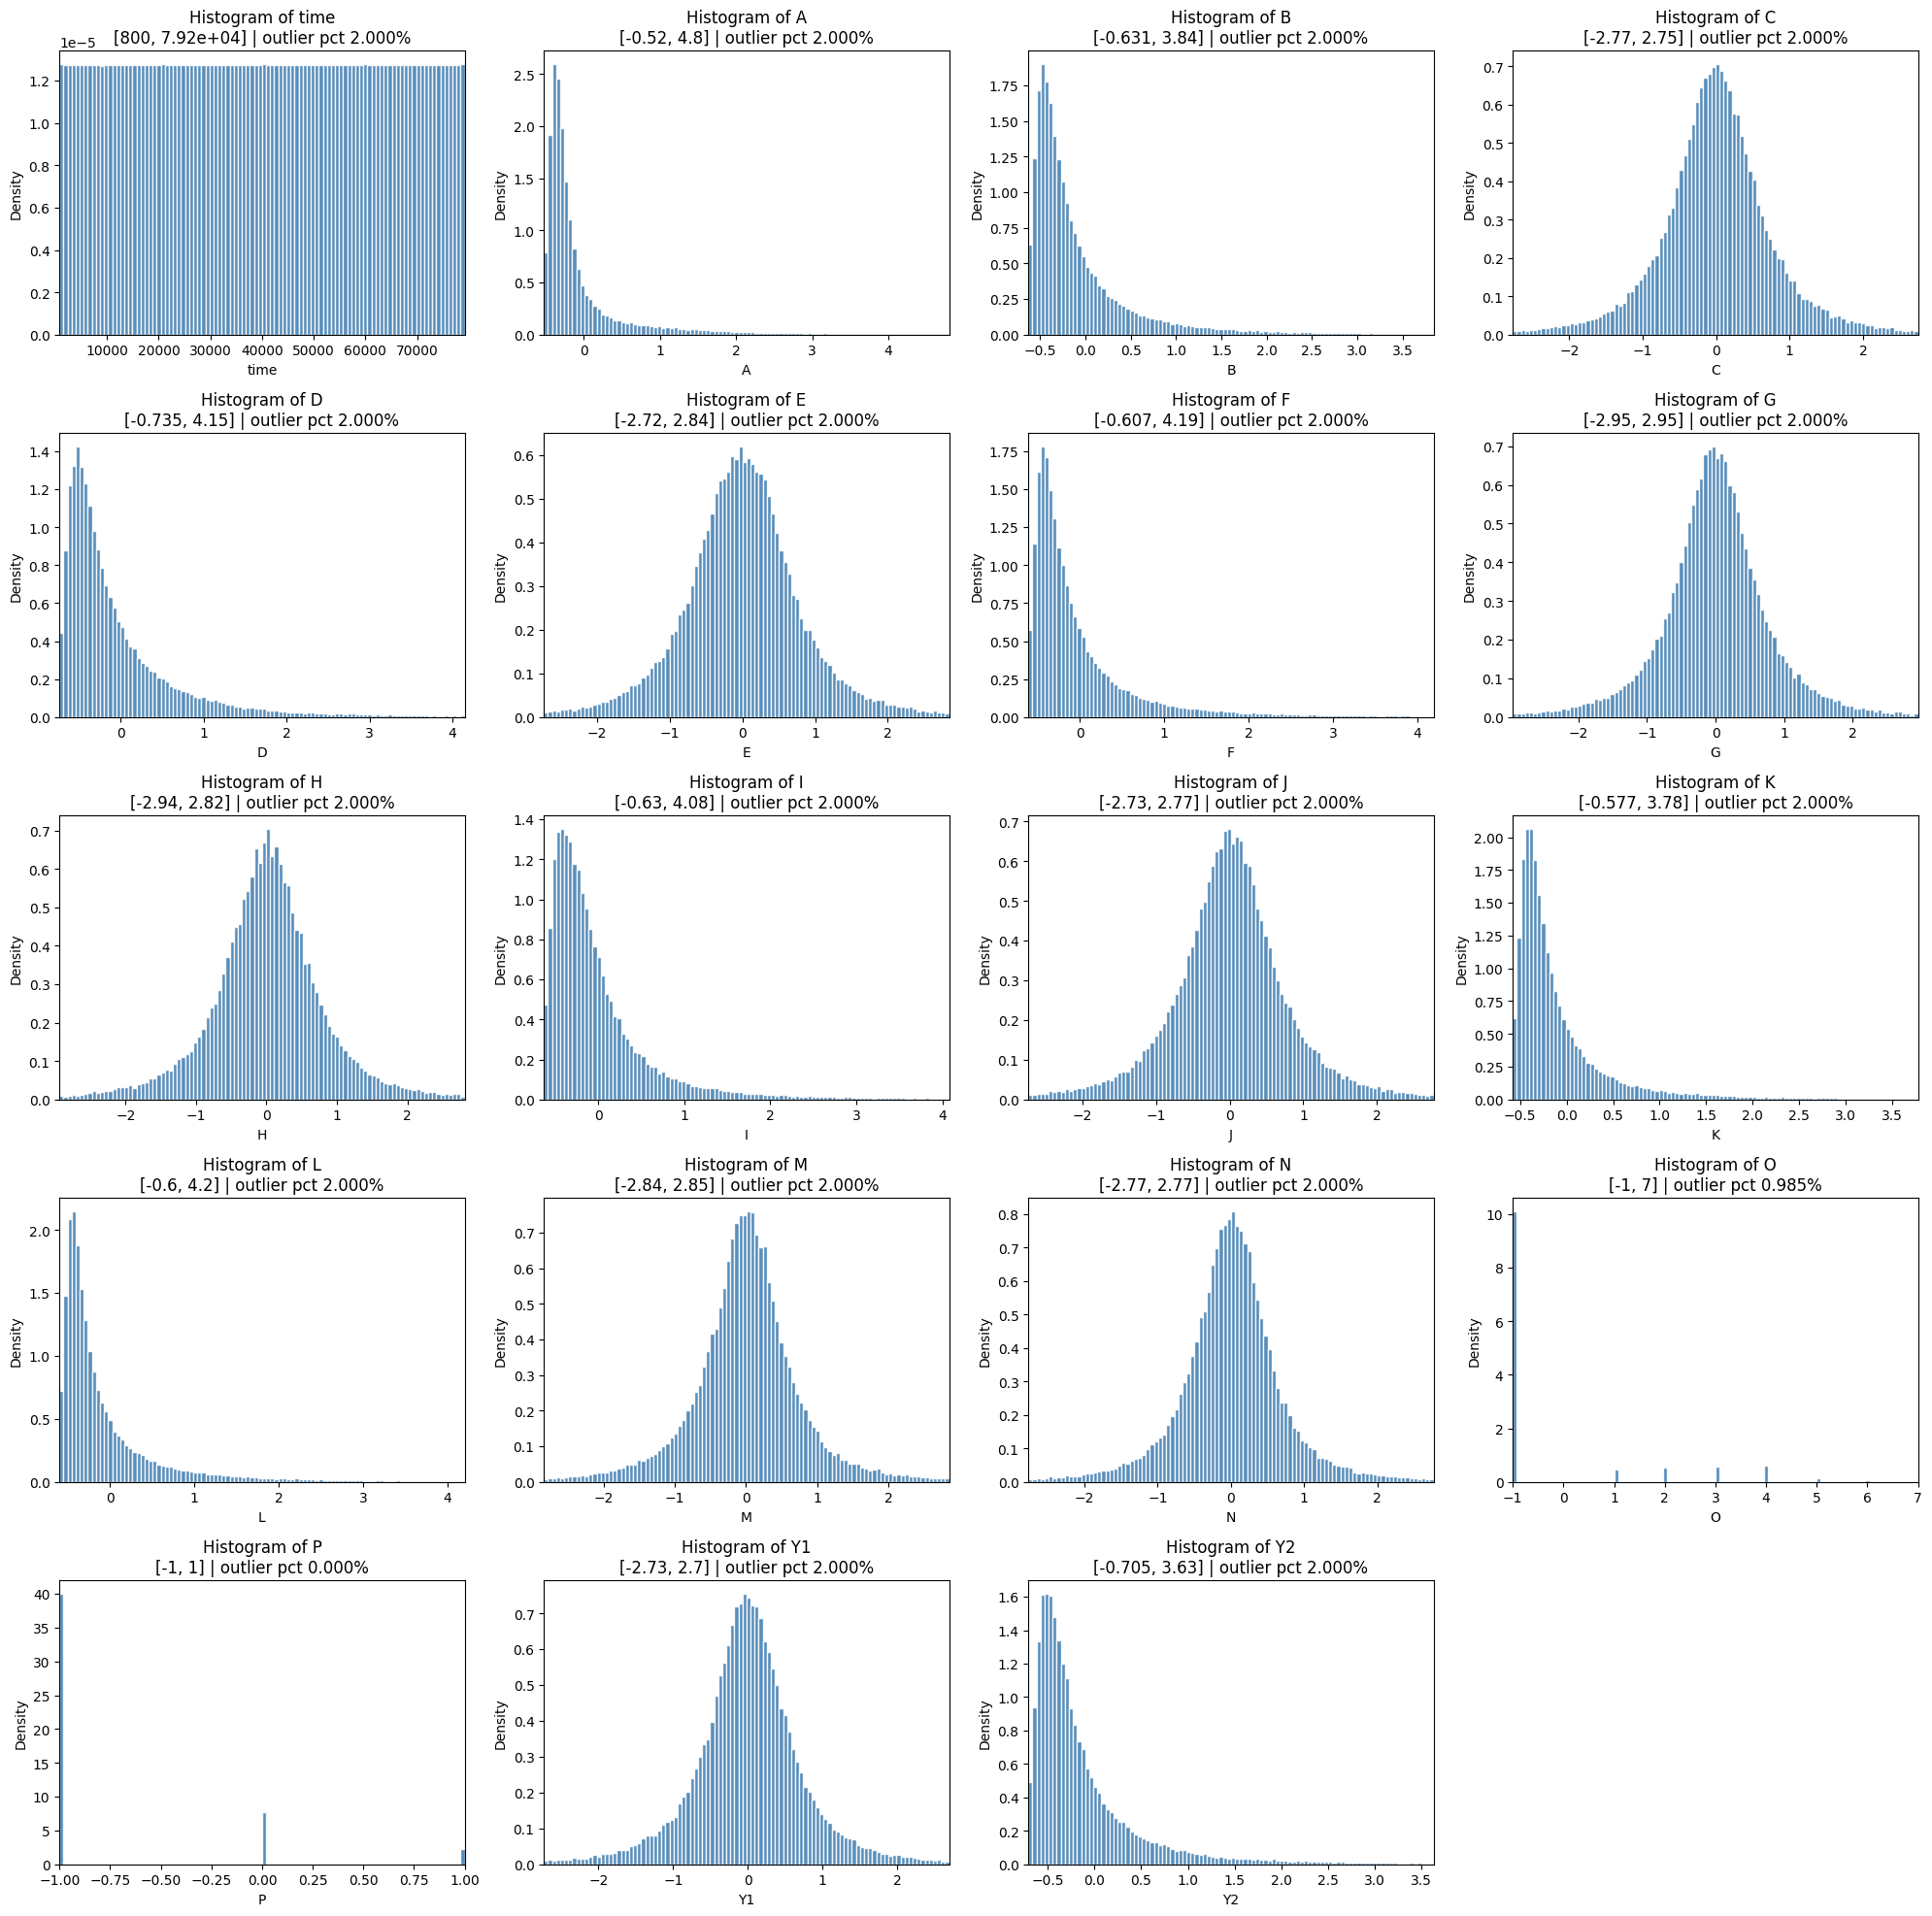

In [82]:
generate_hist(train_data, log_y=False)

### 6) Important statistics

In [83]:
def test_stationarity(series, signif=0.05):
    """
    Ejecuta ADF y KPSS para una serie (pandas Series).
    """
    results = {}
    
    # ADF Test
    adf_res = adfuller(series.dropna(), autolag='AIC')
    results['ADF_stat'] = adf_res[0]
    results['ADF_pval'] = adf_res[1]
    results['ADF_stationary'] = adf_res[1] < signif
    
    # KPSS Test
    try:
        kpss_res = kpss(series.dropna(), regression='c', nlags="auto")
        results['KPSS_stat'] = kpss_res[0]
        results['KPSS_pval'] = kpss_res[1]
        results['KPSS_stationary'] = kpss_res[1] > signif
    except:
        results['KPSS_stat'] = None
        results['KPSS_pval'] = None
        results['KPSS_stationary'] = None
    
    return results


In [84]:
train_data.describe()

statistic,time,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Y1,Y2
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",80000.0,80000.0,80000.0,80000.0,80000.0,80000.0,80000.0,80000.0,80000.0,80000.0,80000.0,80000.0,80000.0,80000.0,80000.0,80000.0,80000.0,80000.0,80000.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",40003.926125,0.068979,-0.004927,-0.000802,0.031913,-0.000292,0.063241,-0.00005,-0.002554,0.070158,-0.000028,-0.000803,0.018752,-0.000636,0.000849,0.157475,-0.7551,-0.002807,-0.061172
"""std""",23095.035045,1.078271,1.031053,1.010158,1.047274,1.036233,1.069182,1.03627,1.040708,1.064972,1.015265,1.038007,1.057857,1.012744,1.025396,18.119762,0.524288,0.970655,0.923702
"""min""",0.0,-0.642788,-0.771179,-30.06821,-0.899105,-29.53071,-0.737694,-35.715053,-23.598892,-0.762271,-34.806015,-0.72914,-0.734872,-29.342481,-49.869913,-1.0,-1.0,-28.91818,-0.850799
"""25%""",20005.0,-0.37417,-0.451917,-0.417825,-0.500602,-0.475687,-0.415164,-0.419795,-0.437465,-0.395449,-0.432181,-0.405347,-0.4384,-0.386473,-0.366044,-1.0,-1.0,-0.387517,-0.497795
"""50%""",40005.0,-0.264494,-0.285344,-0.003935,-0.27907,-0.00675,-0.236953,-0.004947,0.006679,-0.186558,0.003986,-0.263937,-0.292181,0.004218,0.005011,-1.0,-1.0,-0.00158,-0.318087
"""75%""",60004.0,0.005446,0.061002,0.41442,0.166923,0.458873,0.132392,0.421968,0.444976,0.160424,0.437441,0.033414,0.055177,0.387404,0.367432,-1.0,-1.0,0.392468,0.026902
"""max""",80004.0,24.917549,53.667013,29.312756,28.490356,39.3223,46.837612,22.023252,20.634973,33.604551,19.117766,49.278617,38.849874,27.179463,32.488227,3645.0,1.0,29.859458,34.636039


C:\Users\mauro\AppData\Local\Temp\ipykernel_13308\4021521085.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c', nlags="auto")


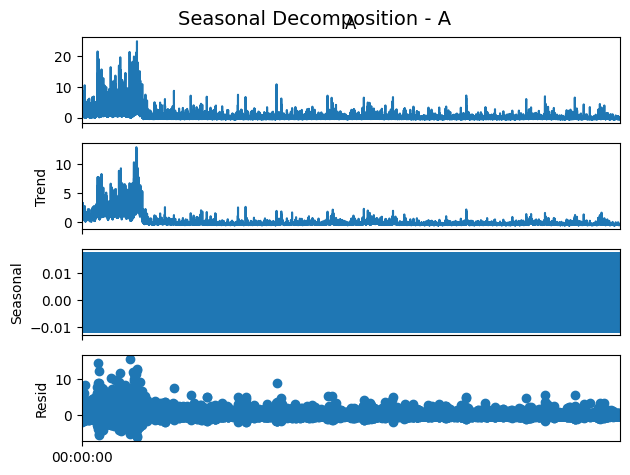

C:\Users\mauro\AppData\Local\Temp\ipykernel_13308\4021521085.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c', nlags="auto")


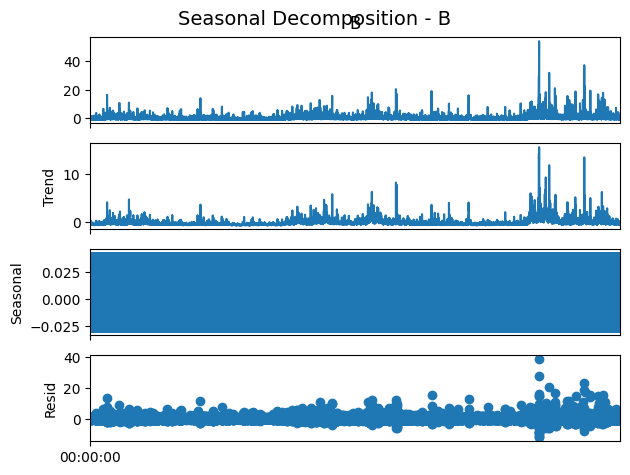

C:\Users\mauro\AppData\Local\Temp\ipykernel_13308\4021521085.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c', nlags="auto")


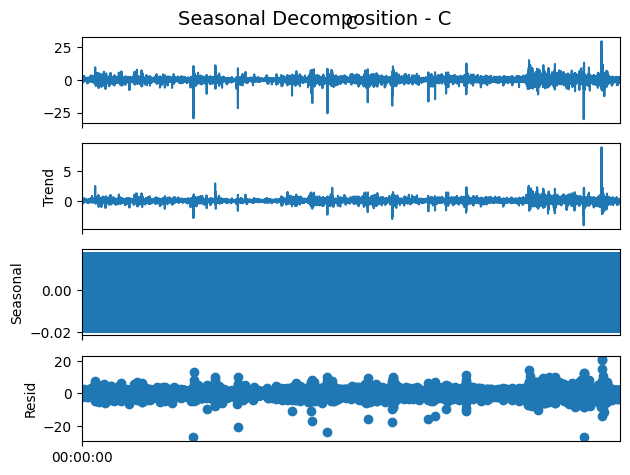

C:\Users\mauro\AppData\Local\Temp\ipykernel_13308\4021521085.py:15: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c', nlags="auto")


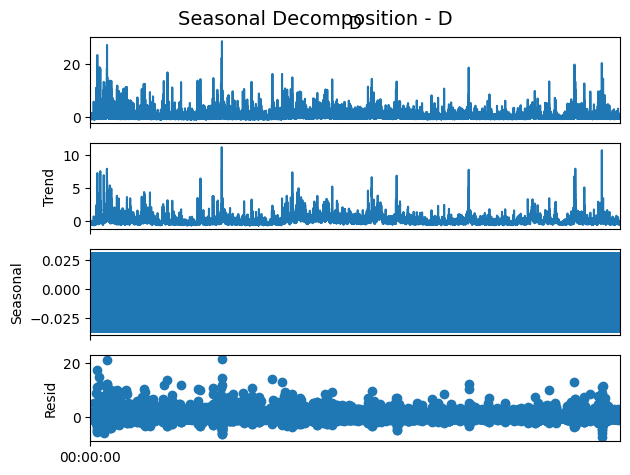

KeyboardInterrupt: 

In [85]:
excluded = ["O","P"]

pdf = train_data.to_pandas()

time = pd.to_datetime(pdf["time"])
pdf = pdf.set_index(time)

summary_stats = {}

for col in pdf.columns:
    if col in excluded or col == "time":
        continue
    
    series = pdf[col].dropna()
    
    results = test_stationarity(series)
    summary_stats[col] = results

    try:
        decomp = seasonal_decompose(series, model='additive', period=12)
        fig = decomp.plot()
        fig.suptitle(f"Seasonal Decomposition - {col}", fontsize=14)
        plt.show()
    except Exception as e:
        print(f"⚠️ No se pudo descomponer {col}: {e}")

summary_df = pd.DataFrame(summary_stats).T
print(summary_df)

### 7) Outlier treatment

In [86]:
def run_pyod_on_polars(
    df: pl.DataFrame,
    cols: list[str] | None = None,
    model: str = "copod",         
    contamination: float = 0.05,
    scale: bool = True,           
    suffix: str = ""
) -> pl.DataFrame:
    if cols is None:
        cols = df.select(cs.numeric()).columns
    X = df.select(cols).to_numpy()

    is_finite = np.isfinite(X).all(axis=1)
    X_clean = X[is_finite]

    scaler = None
    if scale:
        scaler = StandardScaler()
        X_clean = scaler.fit_transform(X_clean)

    if model.lower() == "copod":
        clf = COPOD(contamination=contamination)
    elif model.lower() == "iforest":
        clf = IForest(contamination=contamination, random_state=42)

    clf.fit(X_clean)
    scores_clean = clf.decision_function(X_clean)  # mayor = más outlier
    labels_clean = clf.predict(X_clean)

    scores = np.full(shape=(len(df),), fill_value=np.nan, dtype=float)
    labels = np.full(shape=(len(df),), fill_value=np.nan, dtype=float)

    scores[is_finite] = scores_clean
    labels[is_finite] = labels_clean

    out = df.with_columns(
        pl.Series(f"outlier_score{suffix}", scores),
        pl.Series(f"is_outlier{suffix}", labels).cast(pl.Int8, strict=False)
    )
    return out

In [87]:
mask_time = [c for c in train_data_1.columns if c not in ['time']]
df_scored_all = run_pyod_on_polars(pl.DataFrame(train_data_1[mask_time]), model="copod", contamination=0.02)
df_scored_targets = run_pyod_on_polars(pl.DataFrame(train_data_1[["Y1","Y2"]]), model="copod", contamination=0.02)

dfs_scored = {"all": df_scored_all, "targets": df_scored_targets}

mask_all = df_scored_all["is_outlier"] == 0
mask_targets = df_scored_targets["is_outlier"] == 0
df_clean_all = train_data.filter(mask_all)
df_clean_targets = train_data.filter(mask_targets)

dfs_to_use = {"all": df_clean_all, "targets": df_clean_targets, "none": train_data}

for i in dfs_to_use.values():
    print(i,"\n")

shape: (78_400, 19)
┌───────┬───────────┬───────────┬───────────┬───┬──────┬──────┬───────────┬───────────┐
│ time  ┆ A         ┆ B         ┆ C         ┆ … ┆ O    ┆ P    ┆ Y1        ┆ Y2        │
│ ---   ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---  ┆ ---  ┆ ---       ┆ ---       │
│ i64   ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64  ┆ f64  ┆ f64       ┆ f64       │
╞═══════╪═══════════╪═══════════╪═══════════╪═══╪══════╪══════╪═══════════╪═══════════╡
│ 0     ┆ 0.207366  ┆ -0.159951 ┆ -0.634176 ┆ … ┆ -1.0 ┆ -1.0 ┆ -0.935902 ┆ -0.310081 │
│ 1     ┆ 0.188828  ┆ -0.265508 ┆ 0.042143  ┆ … ┆ -1.0 ┆ -1.0 ┆ -0.089707 ┆ -0.305374 │
│ 2     ┆ -0.144261 ┆ -0.577142 ┆ -0.214634 ┆ … ┆ -1.0 ┆ -1.0 ┆ -0.077855 ┆ -0.631485 │
│ 3     ┆ 0.208982  ┆ -0.310449 ┆ 0.513708  ┆ … ┆ -1.0 ┆ 0.0  ┆ 0.941271  ┆ -0.535212 │
│ 4     ┆ 0.09332   ┆ -0.358156 ┆ 0.173188  ┆ … ┆ -1.0 ┆ -1.0 ┆ -0.039582 ┆ -0.490561 │
│ …     ┆ …         ┆ …         ┆ …         ┆ … ┆ …    ┆ …    ┆ …         ┆ …         │
│ 80000 ┆ -0

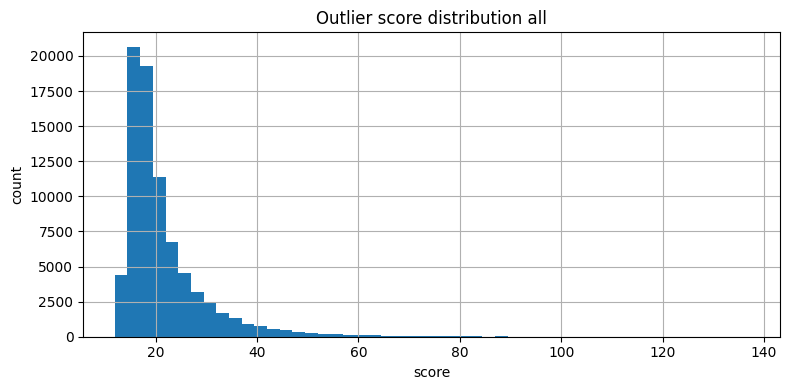

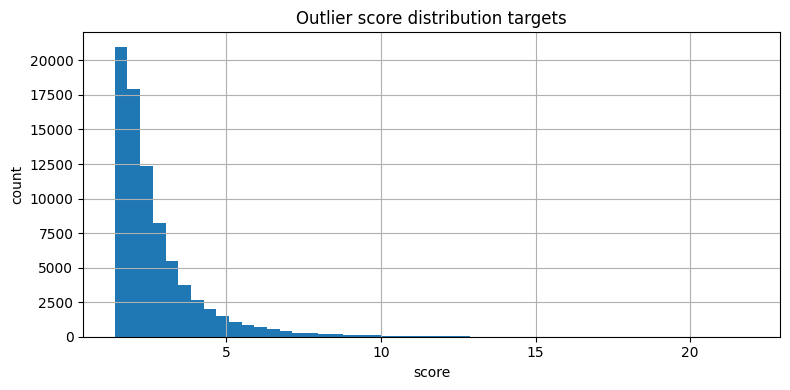

In [88]:
for label, i in dfs_scored.items():

    pdf = i.select(["outlier_score","is_outlier"]).to_pandas()

    plt.figure(figsize=(8,4))
    pdf["outlier_score"].hist(bins=50)
    plt.title(f"Outlier score distribution {label}")
    plt.xlabel("score")
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

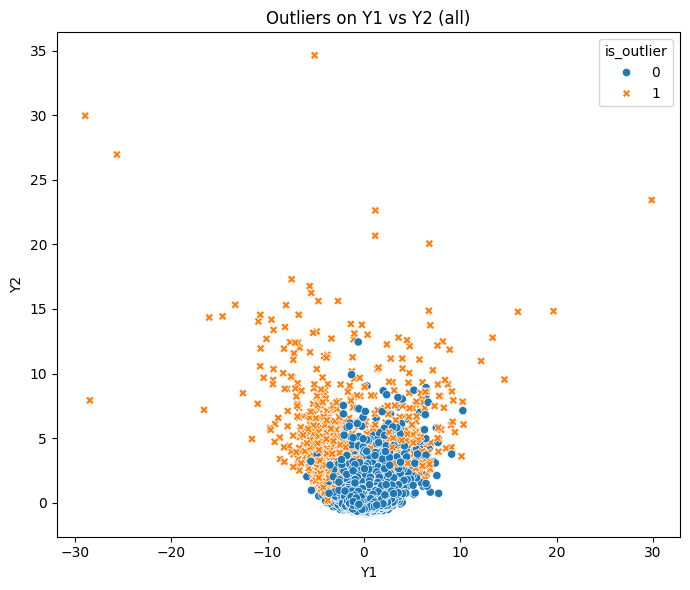

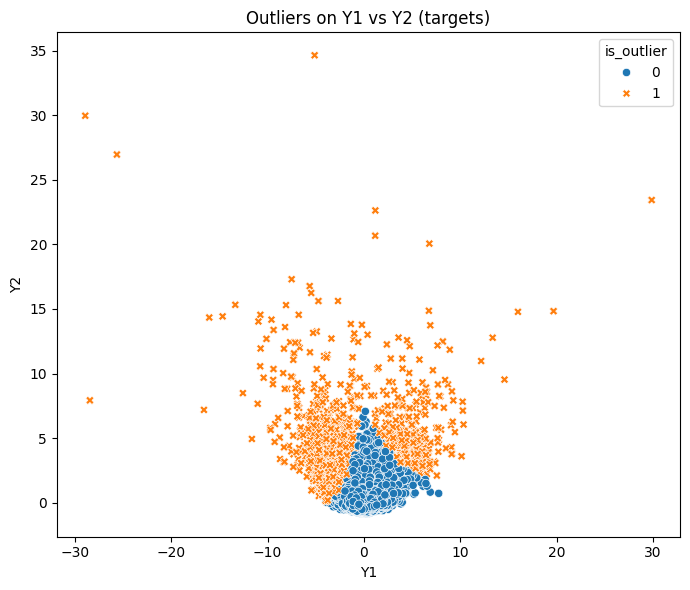

In [89]:
feat_x, feat_y = "Y1", "Y2"   # cámbialos

for label, i in dfs_scored.items():
    pdf2 = i.select([feat_x, feat_y, "is_outlier"]).to_pandas()

    plt.figure(figsize=(7,6))
    sns.scatterplot(
        data=pdf2,
        x=feat_x, y=feat_y,
        hue="is_outlier", style="is_outlier"
    )
    plt.title(f"Outliers on {feat_x} vs {feat_y} ({label})")
    plt.tight_layout()
    plt.show()

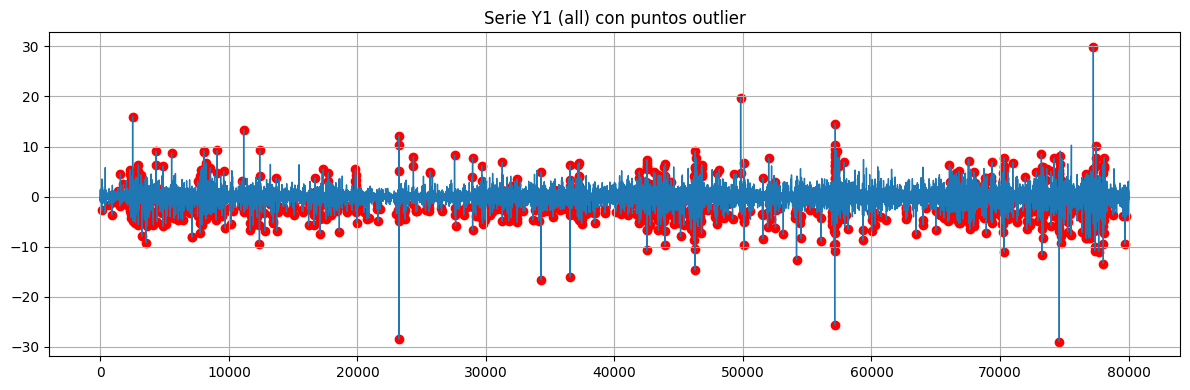

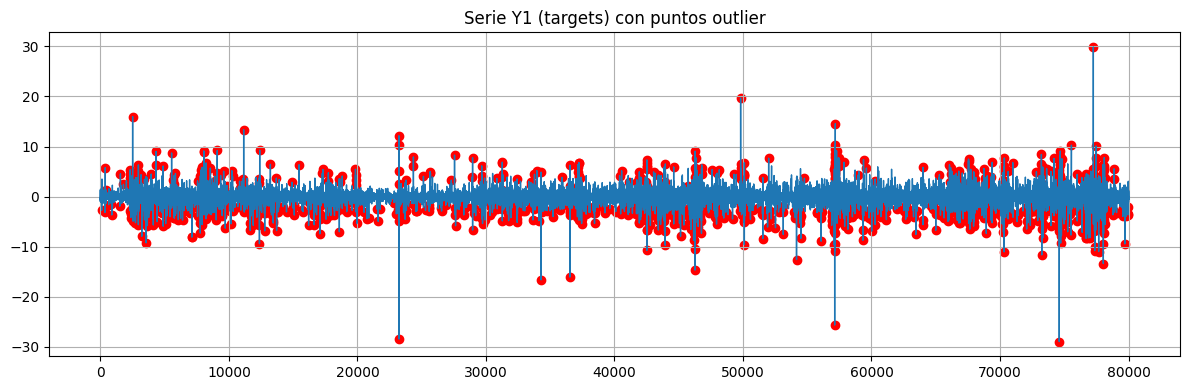

In [90]:
for label, i in dfs_scored.items():

    # añadir índice explícito en Polars
    i_idx = i.with_row_index("row_idx")

    # pasar a pandas
    pdf_ts = i_idx.select(["row_idx","Y1","Y2","is_outlier"]).to_pandas()

    # plot serie completa
    plt.figure(figsize=(12,4))
    plt.plot(train_data["time"].to_pandas(), pdf_ts["Y1"], linewidth=1)

    # seleccionar outliers
    sel = pdf_ts["is_outlier"] == 1

    # scatter en posiciones outlier
    plt.scatter(
        train_data["time"].to_pandas().iloc[pdf_ts.loc[sel,"row_idx"]],
        pdf_ts.loc[sel,"Y1"],
        marker="o", color="red"
    )

    plt.title(f"Serie Y1 ({label}) con puntos outlier")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


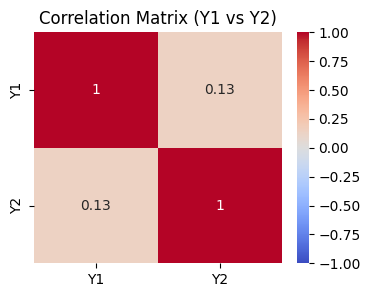

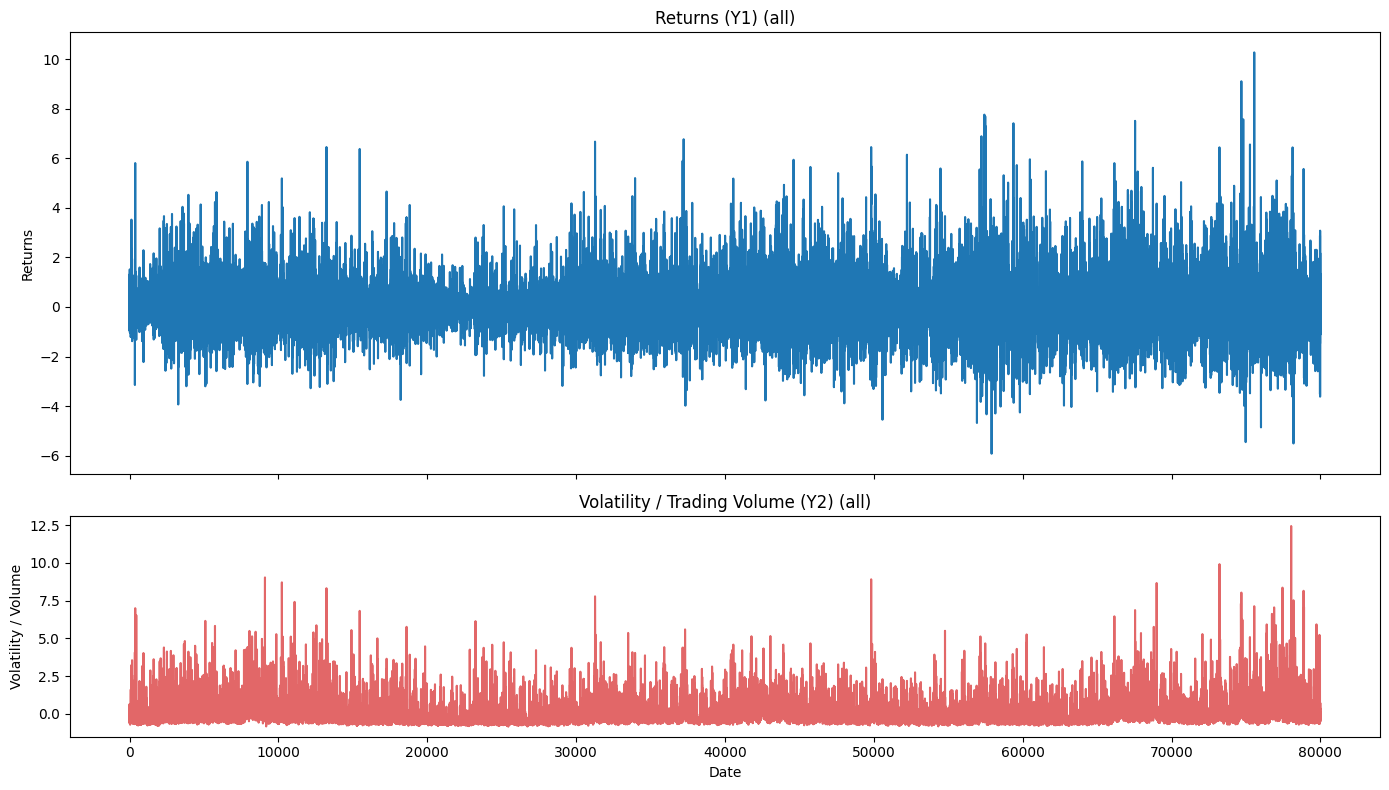

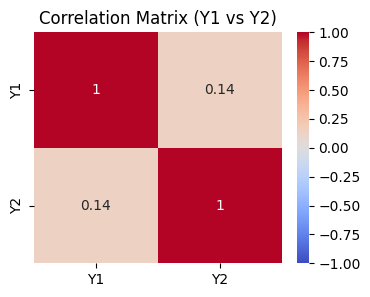

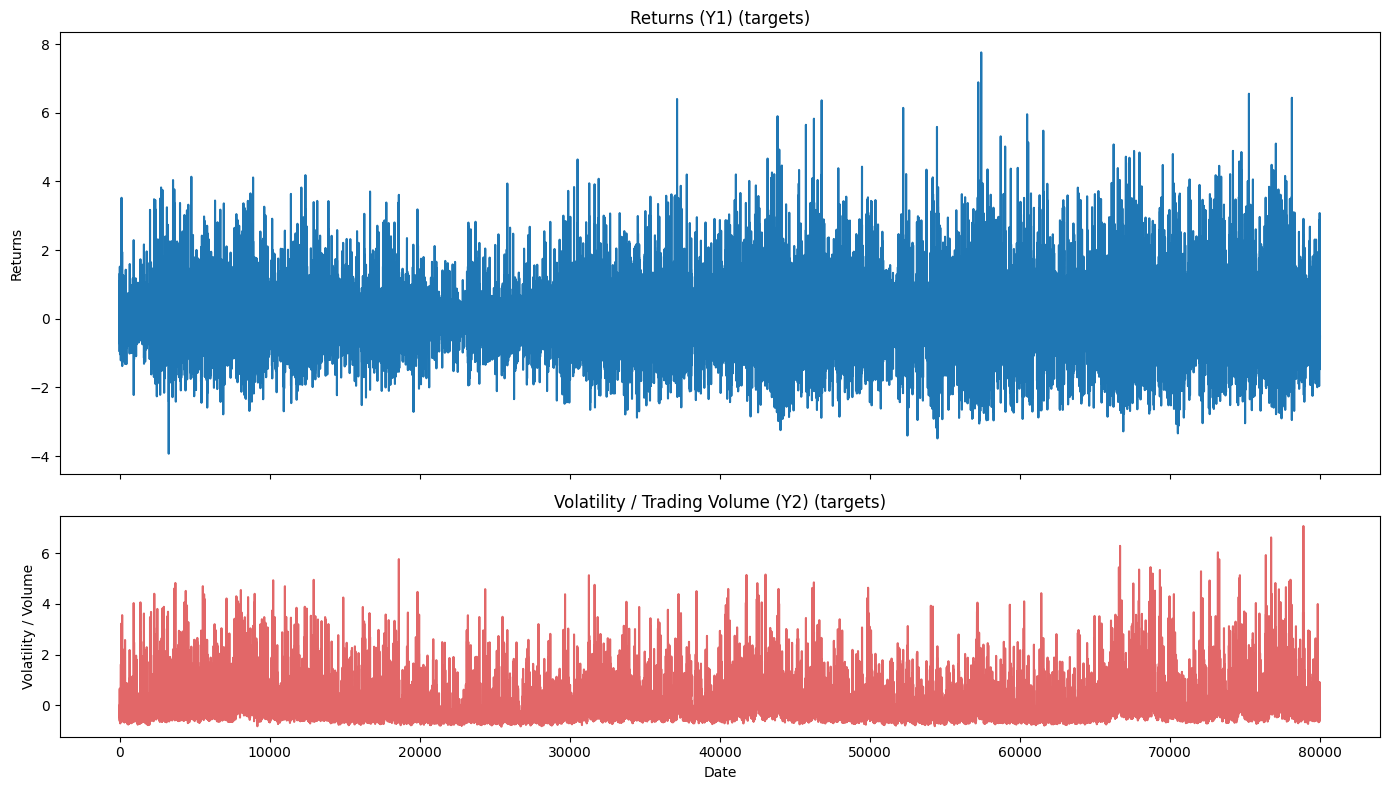

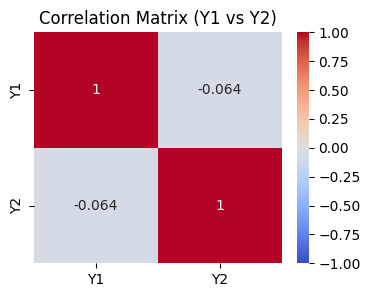

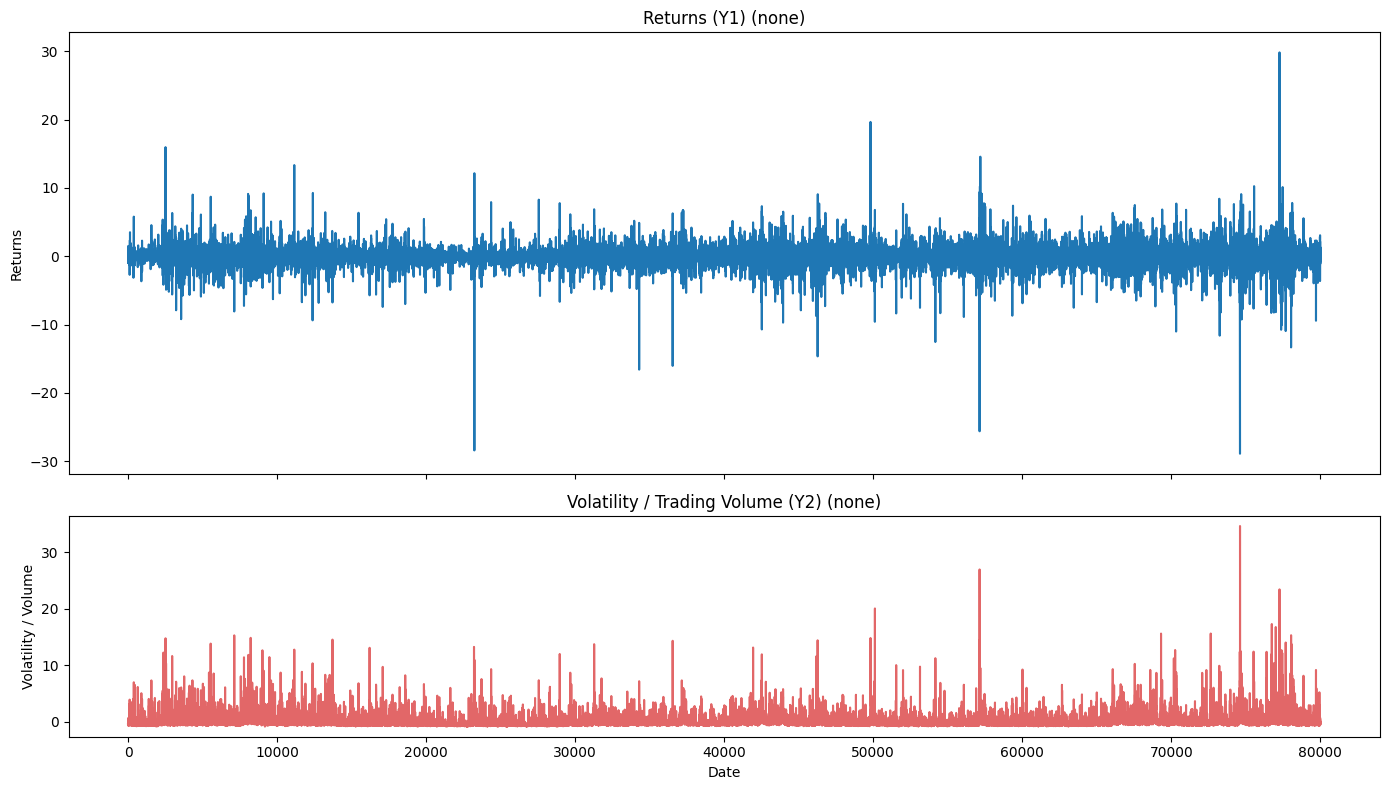

In [91]:
for label, i in dfs_to_use.items():

    pdf = i.select(["time","Y1","Y2"]).to_pandas()

    corr_matrix = pdf[["Y1", "Y2"]].corr(method="pearson")

    plt.figure(figsize=(4,3))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1)
    plt.title("Correlation Matrix (Y1 vs Y2)")
    plt.show()
    print("\n")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,8), sharex=True, gridspec_kw={'height_ratios':[2,1]})

    # Rendimientos arriba
    ax1.plot(pdf["time"], pdf["Y1"], color="tab:blue")
    ax1.set_ylabel("Returns")
    ax1.set_title(f"Returns (Y1) ({label})")

    # Volatilidad/volumen abajo
    ax2.plot(pdf["time"], pdf["Y2"], color="tab:red", alpha=0.7)
    ax2.set_ylabel("Volatility / Volume")
    ax2.set_xlabel("Date")
    ax2.set_title(f"Volatility / Trading Volume (Y2) ({label})")

    plt.tight_layout()
    plt.show()

### 8) Time series statistical analysis

Provide analysis for Y1

In [92]:
for label, df in dfs_to_use.items():

    y_col = "Y1"
    drop_cols = ["O","P"] 
    exog_cols = [c for c in df.columns if c not in ["time", y_col, *drop_cols]]

    pdf = df.select(["time", y_col, *exog_cols]).to_pandas()
    pdf["time"] = pd.to_datetime(pdf["time"])
    pdf = pdf.set_index("time").sort_index()

    y = pdf[y_col]
    X = pdf[exog_cols]

    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        index=X.index,
        columns=X.columns
    )

### 9) ML Models